# Model Training of DDDA model
Model training here contains:
- Dataset only sourced google speech commands dataset
- AudioDataGenerator to perform data augmentation and dynamic downsampling 
- Simple CNN architecture  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow import keras
import seaborn as sns 
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

#from local package 
from modules.data_preprocessing import DataGenerator


## Constants

In [2]:
TARGET_WORD='marvin'
BACKGROUND_WORD="background"
SEED= 32423453
SPEECH_DATA='audio_data'
train_ratio,val_ratio,test_ratio=0.8,0.1,0.1
BATCH_SIZE=32
VAL_BATCH_SIZE=8
IMG_WIDTH=43
IMG_HEIGHT=99
NOISE_FLOOR=0.1

keras.utils.set_random_seed(SEED)

## Setting up files and data generators

In [3]:


def list_subfolders(folder_path):
    subfolders = [f.path[len(folder_path)+1:] for f in os.scandir(folder_path) if f.is_dir()]
    return subfolders

words = list_subfolders(SPEECH_DATA)
classes=[word for word in words if "_" not in word]

#extacting split dataset filenames
import pickle
with open('data/dict_split.pkl', 'rb') as handle:
    split_data = pickle.load(handle)


#Initializing custom data generator that augments the dataset.
datagen_train=DataGenerator(filenames=split_data['train'],
                            classes=classes,
                            data_folder=SPEECH_DATA,
                            noise_floor=NOISE_FLOOR,
                            target=TARGET_WORD,
                            batch_size=BATCH_SIZE,
                            training=True)

datagen_val=DataGenerator(filenames=split_data['val'],
                          classes=classes,
                          data_folder=SPEECH_DATA,
                          noise_floor=NOISE_FLOOR,
                          target=TARGET_WORD,
                          batch_size=VAL_BATCH_SIZE,
                          training=False)

## Model Achitecture

In [5]:
def build_model(kernal_reg=0.0001):
    tf.keras.backend.clear_session()
 
    model = Sequential([
        Conv2D(4, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer1',
               input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)),
        MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
        Conv2D(8, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer2'),
        MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
        Conv2D(16, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer3'),
        MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
        Flatten(),
        Dropout(0.2),
        Dense(
            40,
            activation='relu',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='hidden_layer1'
        ),
        Dense(
            1, 
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='output'
        )
    ])
    return model


In [6]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 49, 21, 4)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 8)         296       
                                                                 
 max_pooling2 (MaxPooling2D)  (None, 24, 10, 8)        0         
                                                                 
 conv_layer3 (Conv2D)        (None, 24, 10, 16)        1168      
                                                                 
 max_pooling3 (MaxPooling2D)  (None, 12, 5, 16)        0         
                                                                 
 flatten (Flatten)           (None, 960)               0

## Training 

In [8]:
epochs=60
patience=10
lr=1e-3


model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",save_weights_only=True,save_best_only=True)

In [9]:
history=model.fit(x=datagen_train,
                  validation_data=datagen_val, 
                  epochs=epochs,
                  callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/60
58/58 [==============================] - 39s 620ms/step - loss: 0.6174 - accuracy: 0.6767 - val_loss: 0.7250 - val_accuracy: 0.5230
Epoch 2/60
58/58 [==============================] - 36s 628ms/step - loss: 0.5705 - accuracy: 0.7139 - val_loss: 0.6341 - val_accuracy: 0.5954
Epoch 3/60
58/58 [==============================] - 36s 625ms/step - loss: 0.5210 - accuracy: 0.7511 - val_loss: 0.5786 - val_accuracy: 0.6941
Epoch 4/60
58/58 [==============================] - 35s 611ms/step - loss: 0.4736 - accuracy: 0.7883 - val_loss: 0.5274 - val_accuracy: 0.7204
Epoch 5/60
58/58 [==============================] - 37s 637ms/step - loss: 0.4719 - accuracy: 0.7856 - val_loss: 0.4795 - val_accuracy: 0.8092
Epoch 6/60
58/58 [==============================] - 43s 742ms/step - loss: 0.4439 - accuracy: 0.8190 - val_loss: 0.4630 - val_accuracy: 0.7895
Epoch 7/60
58/58 [==============================] - 41s 712ms/step - loss: 0.4304 - accuracy: 0.8200 - val_loss: 0.4580 - val_accuracy: 0.7961

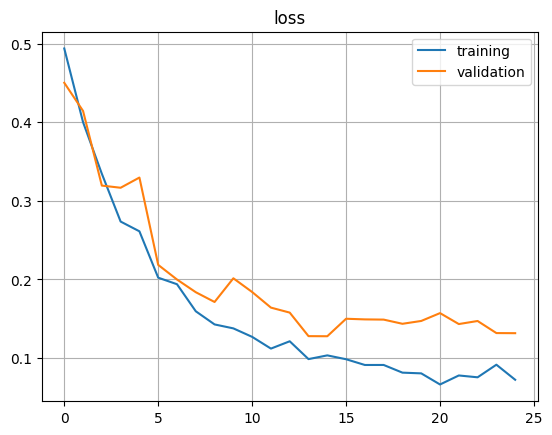

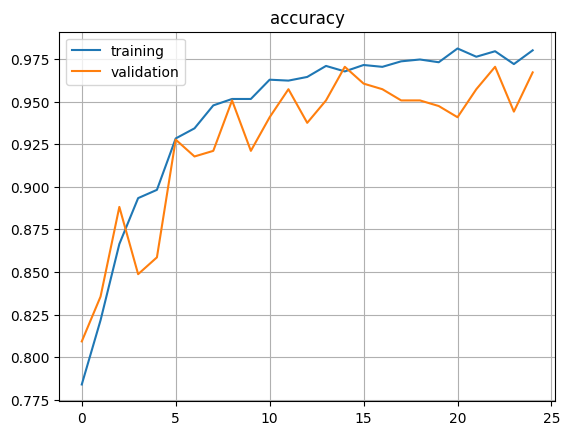

In [18]:
metrics=history.history
plt.plot(metrics['loss'],label='training')
plt.plot(metrics['val_loss'],label='validation')
plt.legend()
plt.title('loss')
plt.grid()
plt.show()

plt.plot(metrics['accuracy'],label='training')
plt.plot(metrics['val_accuracy'],label='validation')
plt.legend()
plt.title('accuracy')
plt.grid()
plt.show()


## Saving Model Weights and training history

In [453]:
model.save('models/model_training5.keras')

# create a binary pickle file 
f = open("data/model5history.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(dict,f)

# close file
f.close()